In [1]:
import operator
from pprint import pprint

from SolrClient import SolrClient

import gensim
from gensim.models import CoherenceModel, LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from treetagger import TreeTagger

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /home/pedro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [3]:
solr = SolrClient('http://192.168.200.201:8080/easysearch')

In [4]:
res = solr.query('default',{
            'q': '-ctr_id:id_document_spell',
            'indent': 'true',
            'fl': 'ctr_id,api_Nome_do_arquivo_tg,api_Conteúdo_tg,api_Título_tg',
            'wt': 'json',
            'rows': '2147483647'
    })

In [5]:
res.get_results_count()

3387

In [6]:
res.docs[0]

{'api_Conteúdo_tg': 'A Pró-Reitora de Gestão e Desenvolvimento de Pessoas da\nUniversidade Federal de São João del-Rei - UFSJ, no uso de suas\natribuições, HOMOLOGA o concurso público para provimento de\ncargo da Carreira de Magistério Superior, CPD 051/2016, na área de\nDERMATOLOGIA, para o Departamento de Medicina (DEMED),\nEdital publicado no DOU do dia 01/08/2016 e torna público seu\nresultado, a saber: 1º LUGAR: VALÉRIA AZEVEDO JUNQUEIRA;\n2° LUGAR: MAHYRA LEITE RIBEIRO.\nEm 28 de setembro de 2016',
 'api_Nome_do_arquivo_tg': 'DO3_2016_09_29_1001.xml',
 'api_Título_tg': 'EDITAL DE HOMOLOGAÇÃO CPD Nº 51/2016',
 'ctr_id': 'da77343019c27110cf9ace0925c6b35cdae2cd6a'}

In [7]:
res.docs[0]['api_Conteúdo_tg']

'A Pró-Reitora de Gestão e Desenvolvimento de Pessoas da\nUniversidade Federal de São João del-Rei - UFSJ, no uso de suas\natribuições, HOMOLOGA o concurso público para provimento de\ncargo da Carreira de Magistério Superior, CPD 051/2016, na área de\nDERMATOLOGIA, para o Departamento de Medicina (DEMED),\nEdital publicado no DOU do dia 01/08/2016 e torna público seu\nresultado, a saber: 1º LUGAR: VALÉRIA AZEVEDO JUNQUEIRA;\n2° LUGAR: MAHYRA LEITE RIBEIRO.\nEm 28 de setembro de 2016'

In [8]:
def preprocess_texts(texts, text_field):
    """
    Function to build tokenized texts from file
    
    Parameters:
    ----------
    fname: File to be read
    
    Returns:
    -------
    yields preprocessed line
    """
    for text in texts:
        yield gensim.utils.simple_preprocess(text[text_field], deacc=False, min_len=3)

In [9]:
train_texts = list(preprocess_texts(res.docs, 'api_Conteúdo_tg'))

In [10]:
def lemmatize(text, language='portuguese'):
    tt = TreeTagger(language=language)
    lemmas = tt.tag(text)
    return [tuples[0] if tuples[2] == '<unknown>' else tuples[2] for tuples in lemmas]
print(lemmatize('Olá, tudo bem com vocês?'))

['olá', ',', 'tudo', 'bem', 'com', 'você', '?']


In [12]:
def lemmatize_texts(texts, language='portuguese'):
    lemmatized = []
    for idx, line in enumerate(texts):
        if idx % 100 == 0:
            logging.log(msg='line ' + str(idx), level=logging.INFO)
        lemmas = lemmatize(line, language=language)
        lemmatized.append([word for word in lemmas])
    return lemmatized

In [21]:
def process_texts(texts, language='portuguese'):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    stops = set(stopwords.words(language))
    #texts = [[word for word in word_tokenize(text) if word.lower() not in stops] for text in texts]
    #print('pós stopwords', texts)
    texts = [[word for word in text if word not in stops] for text in texts]
    
    #texts = [[word for word in lemmatize(line, language=language)] for line in texts]
    texts = lemmatize_texts(texts, language=language)
    
    phrases = gensim.models.Phrases(texts)
    bigram = gensim.models.phrases.Phraser(phrases)
    
    for idx in range(len(texts)):
        for token in bigram[texts[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                texts[idx].append(token)
    
    return texts

In [22]:
%%time
train_texts = process_texts(train_texts)

CPU times: user 6.54 s, sys: 35.7 s, total: 42.2 s
Wall time: 21min 9s


In [23]:
train_texts[0]

['pró_reitor',
 'gestão',
 'desenvolvimento_pessoa',
 'universidade_federal',
 'joão_del',
 'rei_ufsj',
 'uso_atribuição',
 'homologar',
 'concurso_público',
 'provimento',
 'cargo',
 'carreira_magistério',
 'superior_cpd',
 'área',
 'dermatologia',
 'departamento_medicina',
 'demed_edital',
 'publicar_dar',
 'dia',
 'tornar_público',
 'resultar',
 'saber',
 'lugar',
 'valéria',
 'azevedo',
 'junqueira',
 'lugar',
 'mahyra',
 'leite',
 'ribeiro',
 'setembro',
 'pró_reitor',
 'gestão_desenvolvimento_pessoa',
 'universidade_federal_joão_del',
 'rei_ufsj_uso_atribuição',
 'homologar_concurso_público',
 'provimento_cargo',
 'carreira_magistério_superior_cpd',
 'departamento_medicina_demed_edital',
 'publicar_dar',
 'tornar_público_resultar',
 'saber_lugar']

In [24]:
dictionary = Dictionary(train_texts)

In [25]:
print('Number of unique tokens: %d' % len(dictionary))

Number of unique tokens: 26563


In [26]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
# dictionary.filter_extremes(no_below=20, no_above=0.5)
dictionary.filter_extremes(no_above=0.5)
print('Number of unique tokens: %d' % len(dictionary))
#train_texts = [filter(lambda x: x in dictionary.values(), text) for text in train_texts]
corpus = [dictionary.doc2bow(text) for text in train_texts]
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 7932
Number of documents: 3387


In [27]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [28]:
import pyLDAvis.gensim

In [29]:
pyLDAvis.enable_notebook()

In [30]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      17.001110        1       1  0.051033 -0.086970
7      11.878219        1       2  0.082533 -0.029095
8      11.532305        1       3 -0.178278 -0.029572
5      11.480876        1       4  0.083167  0.083821
9       9.884814        1       5  0.123925 -0.038041
0       9.796360        1       6  0.082656  0.093767
6       8.441631        1       7 -0.036254 -0.013132
3       7.487294        1       8  0.074946 -0.031972
4       7.242145        1       9 -0.155920 -0.000836
2       5.255246        1      10 -0.127808  0.052031, topic_info=     Category         Freq                              Term        Total  \
term                                                                        
36    Default  2596.000000                          processo  2596.000000   
4741  Default   299.000000                    turma_recursal   299.000000   
63    Default   877.000000                              item   877.000000   
975   Default   314.000000                      lei_dezembro   314.000000   
4798  Default   391.000000                  seção_judiciário   391.000000   
4468  Default   333.000000                  negar_provimento   333.000000   
2672  Default   328.000000                   uso_competência   328.000000   
519   Default  2106.000000                               art  2106.000000   
5968  Default   316.000000          juizado_especial_federal   316.000000   
6467  Default   499.000000                          proc_adv   499.000000   
5942  Default   409.000000                      resolver_art   409.000000   
152   Default   476.000000                          site_www   476.000000   
260   Default   635.000000                       valor_total   635.000000   
1165  Default   152.000000               técnico_tecnológico   152.000000   
73    Default   780.000000                              ltda   780.000000   
153   Default   326.000000                    comprasnet_gov   326.000000   
5857  Default   230.000000                       nota_fiscal   230.000000   
128   Default   420.000000                  processo_objetar   420.000000   
2591  Default   149.000000  universidade_federal_rio_janeiro   149.000000   
247   Default   699.000000                         contratar   699.000000   
141   Default   383.000000                        total_item   383.000000   
4462  Default   281.000000                    quadro_pessoal   281.000000   
1164  Default   113.000000                     ensino_básico   113.000000   
6471  Default   270.000000                     geral_federal   270.000000   
5851  Default   172.000000             presidência_repúblico   172.000000   
6439  Default   283.000000           incidente_uniformização   283.000000   
342   Default   624.000000                         ltda_cnpj   624.000000   
4534  Default   250.000000                               oab   250.000000   
3321  Default   291.000000                      entrar_vigor   291.000000   
6465  Default   268.000000                   processo_origem   268.000000   
...       ...          ...                               ...          ...   
3153  Topic10    15.749164                  área_abrangência    35.598389   
124   Topic10    21.127591                         ltda_item    53.353407   
260   Topic10   107.985900                       valor_total   635.977195   
519   Topic10   224.938692                               art  2106.191107   
6467  Topic10    63.469644                          proc_adv   499.840202   
386   Topic10    26.589814                    valor_unitário   100.073363   
2076  Topic10    25.621272                        quantidade    99.604981   
4560  Topic10    39.696810                  juizado_especial   237.187958   
36    Topic10   114.291225                          processo  2596.608698   
5941  Topic10    26.123060                      portar_junho   108.671937  

In [31]:
ldatopics = ldamodel.show_topics(formatted=False)

In [52]:
def get_best_model_by_topics(dictionary, corpus, texts, limit, iterations=400):
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    # Set training parameters.
    chunksize = 4000
    passes = 20
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    
    c_v = []
    lm_list = []
    co_va = {}
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, id2word=dictionary, passes=passes, \
                      num_topics=num_topics, chunksize=chunksize, iterations=iterations, \
                      eval_every=eval_every, alpha='auto', eta='auto')
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        co_va[num_topics-1] = cm.get_coherence()
    top_models = sorted(co_va.items(), key=operator.itemgetter(1), reverse=True)
    print('Melhores 5 modelos', top_models[:5])
    return lm_list[top_models[0][0]]

In [53]:
best_model = get_best_model_by_topics(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=6)
print(best_model.show_topics(formatted=False))

/home/pedro/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(4, 0.71911244270782837), (3, 0.63446078350770652), (2, 0.49215642674173288), (1, 0.48117312578503879), (0, 0.4482586926347959)]
[(0, [('site_www', 0.01022229257989833), ('pregão_eletrônico', 0.0089566849253832764), ('processo_objetar', 0.0085976906147617084), ('edital', 0.0079215367033481487), ('total_item', 0.0074189016857484002), ('comprasnet_gov', 0.0065781192994496737), ('sidec', 0.0065435794764837534), ('licitação', 0.0052289834034563191), ('dia', 0.0052225419294354772), ('licitar_edital', 0.0050771944945687195)]), (1, [('art', 0.014299363862530308), ('publicar_dar', 0.0074895070936044665), ('processo', 0.006665674464016654), ('portar', 0.0066556759190859825), ('uso_atribuição', 0.0063615579414310489), ('lei', 0.005391771987574151), ('matrícula_siape', 0.0053265659286456353), ('resolver_art', 0.0049228020785738423), ('datar_publicação', 0.0045936138373459294), ('edital', 0.0036489122912589716)]), (2, [('proc_adv', 0.014618655515773522), ('federal', 0.010020018

In [54]:
best_model = get_best_model_by_topics(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=10, iterations=400)
print(best_model.show_topics(formatted=True))

/home/pedro/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(7, 0.76038206804833885), (4, 0.71172226763166702), (5, 0.7089338462590743), (8, 0.70185729063227142), (6, 0.6501880019006584)]
[(0, '0.017*"contratar" + 0.015*"valor_total" + 0.013*"processo" + 0.012*"contrato" + 0.012*"datar_assinatura" + 0.012*"item" + 0.011*"valor" + 0.011*"fundamento_legal" + 0.009*"cnpj" + 0.009*"lei"'), (1, '0.024*"art" + 0.008*"lei" + 0.007*"uso_atribuição" + 0.007*"processo" + 0.007*"empresa" + 0.006*"resolver_art" + 0.005*"termo" + 0.005*"datar_publicação" + 0.005*"matrícula_siape" + 0.004*"federal"'), (2, '0.013*"proc_adv" + 0.012*"federal" + 0.010*"art" + 0.009*"turma_recursal" + 0.009*"geral_federal" + 0.008*"seção_judiciário" + 0.008*"processo_origem" + 0.007*"parte_ora" + 0.006*"juizado_especial" + 0.006*"adv_procuradoria"'), (3, '0.018*"pregão_eletrônico" + 0.018*"processo_objetar" + 0.018*"site_www" + 0.016*"total_item" + 0.015*"comprasnet_gov" + 0.015*"sidec" + 0.011*"licitar_edital" + 0.011*"processo_objetar_pregão_eletrônico" + 0

In [55]:
best_model = get_best_model_by_topics(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=10, iterations=200)
print(best_model.show_topics(formatted=True))

/home/pedro/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(2, 0.74108879797456095), (3, 0.71228224253852623), (6, 0.67144915598044441), (8, 0.66278593488136339), (4, 0.60902735288539556)]
[(0, '0.012*"processo" + 0.011*"art" + 0.007*"lei" + 0.005*"uso_atribuição" + 0.005*"publicar_dar" + 0.005*"matrícula_siape" + 0.005*"portar" + 0.004*"datar_publicação" + 0.004*"resolver_art" + 0.003*"servidor"'), (1, '0.008*"item" + 0.007*"processo" + 0.007*"valor_total" + 0.007*"contratar" + 0.006*"pregão_eletrônico" + 0.006*"valor" + 0.005*"empresa" + 0.005*"contrato" + 0.005*"serviço" + 0.005*"site_www"'), (2, '0.014*"proc_adv" + 0.010*"federal" + 0.009*"turma_recursal" + 0.008*"seção_judiciário" + 0.008*"incidente_uniformização" + 0.008*"geral_federal" + 0.007*"processo_origem" + 0.006*"art" + 0.006*"turma_nacional" + 0.005*"parte_ora"')]


In [56]:
best_model = get_best_model_by_topics(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=10, iterations=600)
print(best_model.show_topics(formatted=True))

/home/pedro/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(8, 0.71731432300835951), (5, 0.6943668529370437), (7, 0.66940357919056426), (2, 0.65469006851150813), (3, 0.63487985584004902)]
[(0, '0.009*"item" + 0.007*"edital" + 0.007*"licitação" + 0.007*"tornar_público" + 0.006*"valor" + 0.006*"empresa" + 0.006*"dia" + 0.006*"dever_ser" + 0.005*"serviço" + 0.005*"município"'), (1, '0.026*"item" + 0.022*"ltda" + 0.020*"ltda_cnpj" + 0.019*"valor_total" + 0.015*"cnpj" + 0.014*"ltda_epp" + 0.009*"valor" + 0.009*"empresa" + 0.008*"atar" + 0.006*"valor_global"'), (2, '0.013*"www_comprasnet" + 0.012*"pregão_eletrônico" + 0.008*"total_item" + 0.008*"sidec" + 0.007*"entregar_propor" + 0.007*"propor_site" + 0.007*"gov_abertura" + 0.007*"partir_site" + 0.006*"processo_objetar" + 0.006*"processo_objetar_pregão_eletrônico"'), (3, '0.011*"art" + 0.005*"processo" + 0.005*"lei" + 0.004*"dia" + 0.004*"técnico" + 0.004*"público" + 0.003*"saúde" + 0.003*"dever" + 0.003*"dever_ser" + 0.003*"termo"'), (4, '0.035*"processo" + 0.022*"art" + 0.008*"

In [ ]:
# Build topic listings from each model.
import itertools
from gensim import matutils

def top_topics(lda, num_words=20):
    str_topics = []
    for topic in lda.state.get_lambda():
        print(topic)
        topic = topic / topic.sum()  # normalize to probability distribution
        print(topic)
        bestn = matutils.argsort(topic, topn=num_words, reverse=True)
        print('bestn', bestn)
        beststr = [lda.id2word[_id] for _id in bestn]
        print('beststr', beststr)
        str_topics.append(beststr)
    print(str_topics)
    return str_topics


model_topics = {}
super_topic = set()
for num_topics, model in best_model.items():
    topics_as_topn_terms = top_topics(model)
    model_topics[num_topics] = topics_as_topn_terms
    super_topic.update(itertools.chain.from_iterable(topics_as_topn_terms))
    
print("Number of relevant terms: %d" % len(super_topic))

In [33]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

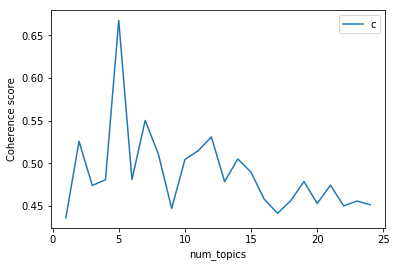

CPU times: user 5min 16s, sys: 46 s, total: 6min 2s
Wall time: 5min 27s


In [34]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=25)

In [35]:
print(c_v)

[0.43590528041387894, 0.52583367526440616, 0.47409543106053292, 0.48077797185165605, 0.66770040225041716, 0.48095505894624702, 0.55029429160137255, 0.51060647128416747, 0.44717781332976486, 0.50444737806526974, 0.51472081975752948, 0.53103378277920266, 0.47862727581199888, 0.50516623912106418, 0.48955290500423576, 0.45784242196309194, 0.44144669866369357, 0.45621662612860764, 0.4786562280061924, 0.45288988572209654, 0.47441853792734084, 0.45018229021496148, 0.45578476740127666, 0.4514645302936458]


In [36]:
print(c_v[4])

0.66770040225


In [37]:
pyLDAvis.gensim.prepare(lmlist[4], corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      26.208656        1       1 -0.058801  0.083529
4      25.044191        1       2 -0.085617 -0.097622
0      21.280261        1       3 -0.068615  0.022448
2      15.071248        1       4  0.192052 -0.010118
3      12.395643        1       5  0.020982  0.001764, topic_info=     Category         Freq                                Term        Total  \
term                                                                          
63    Default   878.000000                                item   878.000000   
6467  Default   509.000000                            proc_adv   509.000000   
4741  Default   327.000000                      turma_recursal   327.000000   
153   Default   542.000000                      comprasnet_gov   542.000000   
152   Default   715.000000                            site_www   715.000000   
38    Default   771.000000                   pregão_eletrônico   771.000000   
260   Default   664.000000                         valor_total   664.000000   
6471  Default   273.000000                       geral_federal   273.000000   
5942  Default   510.000000                        resolver_art   510.000000   
6439  Default   289.000000             incidente_uniformização   289.000000   
6465  Default   275.000000                     processo_origem   275.000000   
519   Default  2194.000000                                 art  2194.000000   
310   Default   270.000000                           registrar   270.000000   
142   Default   377.000000                      licitar_edital   377.000000   
151   Default   296.000000                       propor_partir   296.000000   
149   Default   312.000000                             www_gov   312.000000   
4798  Default   356.000000                    seção_judiciário   356.000000   
141   Default   474.000000                          total_item   474.000000   
150   Default   293.000000                     edital_entregar   293.000000   
4560  Default   192.000000                    juizado_especial   192.000000   
6469  Default   198.000000                           inss_proc   198.000000   
6470  Default   197.000000                    adv_procuradoria   197.000000   
6441  Default   200.000000                           parte_ora   200.000000   
16    Default   623.000000                        publicar_dar   623.000000   
157   Default   343.000000  processo_objetar_pregão_eletrônico   343.000000   
6592  Default   216.000000                      turma_nacional   216.000000   
128   Default   508.000000                    processo_objetar   508.000000   
159   Default   341.000000           total_item_licitar_edital   341.000000   
975   Default   339.000000                        lei_dezembro   339.000000   
154   Default   336.000000                     abertura_propor   336.000000   
...       ...          ...                                 ...          ...   
1271   Topic5    38.579694                    empresa_vencedor    77.462213   
67     Topic5    87.450378                             produto   295.844047   
1371   Topic5    47.640048                             emissão   111.575898   
503    Topic5    93.696227                                 ser   366.419782   
7512   Topic5   150.000777                     matrícula_siape   846.967008   
4462   Topic5    99.302507                      quadro_pessoal   412.110218   
284    Topic5    87.499147                        valor_global   334.286378   
2193   Topic5    74.313239                               datar   250.330130   
365    Topic5   100.245252                               dever   445.194978   
597    Topic5    77.521634                            seguinte   296.357083   
65     Topic5   117.545115                             empresa   707.343873   
4798   Topic5    83.299892                    seção_judiciário   356.750319   
519    Topic5   190.0096

In [40]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = get_best_model_by_topics(corpus=corpus, dictionary=dictionary, limit=50, texts=train_texts)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
        print('Melhores 5 modelos', top_topics[:5])
    return lm, top_topics

In [36]:
logging.disable(level=logging.INFO)

In [41]:
%%time
lm, top_topics = ret_top_model()

/home/pedro/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(5, 0.73169988798851271), (6, 0.71814579497499709), (3, 0.70086624055723812), (8, 0.69283338471343381), (16, 0.69105868521961733)]
Melhores 5 modelos [(1, 0.49153038747834793), (3, 0.44309482355181345), (0, 0.43110158015085565), (2, 0.40061933994606369), (4, 0.3110018845401829)]
Melhores 5 modelos [(4, 0.69710422491541302), (6, 0.69404891378665534), (8, 0.68678316062030731), (11, 0.67126412647894373), (5, 0.66767950243178775)]
Melhores 5 modelos [(0, 0.4885467543531396), (4, 0.41963539439982139), (2, 0.40061933994606358), (1, 0.35394331687792369), (3, 0.26719702343250151)]
Melhores 5 modelos [(6, 0.7830594008182562), (4, 0.71760172308584602), (11, 0.68522395617128784), (10, 0.67995211597921457), (5, 0.65671638010587141)]
Melhores 5 modelos [(1, 0.56142051842803409), (0, 0.44998082398855033), (3, 0.40061933994606358), (5, 0.36856048288168497), (2, 0.28381836930200388)]
Melhores 5 modelos [(8, 0.71590185433575781), (7, 0.71514098432779905), (6, 0.70801810375746099), (

KeyboardInterrupt: 

In [35]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

[[('proc_adv', 0.016016731893559868),
  ('incidente_uniformizacao', 0.012829814647509962),
  ('turma_recursal', 0.010936625295985868),
  ('inss_proc', 0.0091306983065047899),
  ('adv_procuradoria', 0.0090731010745261562),
  ('geral_federal', 0.0090731010745261562),
  ('parte_ora', 0.0089602210762516534),
  ('trata_agravo', 0.0087707625168775873),
  ('decisao_inadmitiu', 0.0086072663449699785),
  ('oab_requerido', 0.0083177163107341027)],
 [('comprasnet_gov', 0.027017224699846496),
  ('site_www', 0.02529700182894204),
  ('objeto_pregao', 0.018273239373618657),
  ('processo', 0.017400868819024449),
  ('abertura_propostas', 0.016551539482735283),
  ('propostas_partir', 0.016024489602518018),
  ('total_itens', 0.015450838906475283),
  ('edital_entrega', 0.01466498751076112),
  ('www_gov', 0.014505528771094914),
  ('licitados_edital', 0.01427815875000788)],
 [('codigo', 0.0098117947182114144),
  ('turma_recursal', 0.0092078500893413729),
  ('proc_adv', 0.0080897032116355461),
  ('incidente_

In [43]:
pyLDAvis.gensim.prepare(lm, corpus,       dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
4      5.002951        1       1 -0.390125 -0.036099
5      3.575705        1       2 -0.022637  0.180683
24     2.477793        1       3  0.070474 -0.029306
36     2.476030        1       4  0.018813  0.117893
72     2.272221        1       5  0.101304  0.005740
29     2.040274        1       6  0.096014 -0.055481
10     2.015970        1       7  0.034471 -0.017698
33     1.997512        1       8 -0.352434 -0.010864
76     1.812089        1       9  0.034875  0.042069
48     1.639230        1      10 -0.290535  0.037545
96     1.590694        1      11  0.071052 -0.017431
13     1.546939        1      12 -0.055480  0.005160
20     1.542378        1      13  0.061909  0.015141
78     1.526152        1      14  0.025200  0.002911
95     1.497165        1      15  0.064531 -0.012988
73     1.495734        1      16  0.016071  0.017601
85     1.432516        1      17  0.081672 -0.009027
8      1.396610        1      18 -0.280899  0.052196
46     1.390328        1      19  0.075234  0.148496
92     1.364753        1      20 -0.034771 -0.045221
63     1.350009        1      21  0.071802  0.019641
12     1.340904        1      22 -0.038872 -0.050807
15     1.314007        1      23  0.086328 -0.046006
83     1.296976        1      24  0.097731 -0.078775
55     1.276031        1      25 -0.172338  0.085062
31     1.249677        1      26  0.022550  0.039066
56     1.177628        1      27 -0.057871 -0.025176
90     1.165912        1      28  0.072910 -0.068320
47     1.158943        1      29  0.026099  0.115509
93     1.130407        1      30 -0.024427 -0.090750
...         ...      ...     ...       ...       ...
17     0.623098        1      71  0.068399  0.061484
39     0.611907        1      72 -0.008856  0.020029
40     0.599354        1      73  0.052906 -0.105208
97     0.578776        1      74  0.077977 -0.023870
57     0.552933        1      75  0.028425 -0.049248
58     0.552239        1      76 -0.019148 -0.091558
70     0.544983        1      77  0.084248  0.049683
7      0.544079        1      78 -0.120277 -0.099871
77     0.536104        1      79  0.034853 -0.021374
61     0.533028        1      80 -0.009357  0.045906
52     0.527977        1      81  0.030299  0.061488
38     0.517422        1      82 -0.013804  0.082175
79     0.505000        1      83 -0.145423  0.083312
18     0.490175        1      84 -0.052268 -0.078556
66     0.482309        1      85 -0.008728  0.021974
2      0.469946        1      86  0.033046  0.041294
9      0.462770        1      87 -0.183742  0.020642
25     0.443844        1      88  0.042634 -0.040058
11     0.432519        1      89  0.052711 -0.026380
37     0.432399        1      90  0.054880 -0.002248
87     0.432293        1      91  0.083387 -0.016078
0      0.426041        1      92  0.040855 -0.068819
30     0.413210        1      93 -0.041688 -0.027159
75     0.407997        1      94 -0.009008 -0.066735
91     0.401531        1      95  0.000840 -0.051953
82     0.396238        1      96  0.009260  0.087013
89     0.388531        1      97  0.039328 -0.077704
35     0.378135        1      98  0.045841  0.014267
32     0.285215        1      99  0.008807  0.011213
81     0.260842        1     100 -0.028100 -0.032002

[100 rows x 5 columns], topic_info=       Category         Freq                        Term        Total  \
term                                                                    
13572   Default   435.000000                  vigor_data   435.000000   
7919    Default   304.000000              quadro_pessoal   304.000000   
63      Default  1011.000000                        item  1011.000000   
583     Default  1776.000000                         art  1776.000000   
2767    Default   637.000000                      codigo   637.000000   
14098   Default   254.000000                 resolve_art   254.000000   
6561    De